In [2]:
# installing all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder , LabelEncoder , OneHotEncoder
from sklearn.model_selection import train_test_split
import cassandra
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

# installing cassandra db 
!pip install cassandra-driver

cassandra databse credentials
path_for_bundle = 'D:\\Downloads\\ML projects\\adult income prediction Ineuron_internship-main\\Cassandra Db Details\\secure-connect-db-income.zip'
client_ID = pd.read_csv('GeneratedToken.csv')['Client Id'][0]
client_secret = pd.read_csv('GeneratedToken.csv')['Client Secret'][0]

FileNotFoundError: [Errno 2] No such file or directory: 'GeneratedToken.csv'

In [ ]:
client_secret

In [12]:
from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthProvider

cloud_config= {
        'secure_connect_bundle': path_for_bundle
}
auth_provider = PlainTextAuthProvider(client_ID,client_secret)
cluster = Cluster(cloud=cloud_config, auth_provider=auth_provider)
session = cluster.connect()
row = session.execute("select release_version from system.local").one()
if row:
    print(row[0])
else:
    print("An error occurred.")

4.0.0.6816


In [14]:
#use keyspace
row=session.execute("use ks_income;")

In [16]:
df =pd.DataFrame(data=session.execute("select * from tb_income;"))
df.drop(['key'],axis=1,inplace=True)
df
# df=pd.read_csv('D:\\Downloads\\ML projects\\adult income prediction Ineuron_internship-main - Copy\\adult.csv')

,key,age,capital_gain,capital_loss,country,education,education_num,fnlwgt,hours_per_week,marital_status,occupation,race,relationship,salary,sex,workclass
0,4317,65,0,0,United-States,Some-college,10,225473,35,Widowed,Craft-repair,White,Not-in-family,<=50K,Female,Self-emp-not-inc
1,25269,22,0,0,United-States,Assoc-acdm,12,188274,40,Never-married,Handlers-cleaners,White,Own-child,<=50K,Male,Private
2,3372,20,0,0,United-States,Some-college,10,235442,35,Never-married,?,White,Own-child,<=50K,Male,?
3,14340,43,0,0,United-States,Some-college,10,101709,40,Divorced,Handlers-cleaners,Asian-Pac-Islander,Not-in-family,<=50K,Male,Federal-gov
4,18417,24,0,0,United-States,Some-college,10,32921,50,Never-married,Farming-fishing,White,Own-child,<=50K,Male,Private
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,3476,34,0,0,United-States,Some-college,10,114691,50,Married-civ-spouse,Exec-managerial,White,Husband,>50K,Male,Private
32557,2542,34,0,0,United-States,Some-college,10,193036,40,Married-civ-spouse,Adm-clerical,Black,Husband,>50K,Male,Private
32558,6931,31,0,0,United-States,Some-college,10,50442,25,Never-married,Adm-clerical,Amer-Indian-Eskimo,Own-child,<=50K,Female,Local-gov
32559,11033,33,0,0,El-Salvador,5th-6th,3,348618,20,Married-spouse-absent,Transport-moving,Other,Unmarried,<=50K,Male,Private


# Analyzing data

In [22]:
df.head()

,index,age,capital_gain,capital_loss,country,education,education_num,fnlwgt,hours_per_week,marital_status,occupation,race,relationship,salary,sex,workclass
0,4317,65,0,0,United-States,Some-college,10,225473,35,Widowed,Craft-repair,White,Not-in-family,<=50K,Female,Self-emp-not-inc
1,25269,22,0,0,United-States,Assoc-acdm,12,188274,40,Never-married,Handlers-cleaners,White,Own-child,<=50K,Male,Private
2,3372,20,0,0,United-States,Some-college,10,235442,35,Never-married,?,White,Own-child,<=50K,Male,?
3,14340,43,0,0,United-States,Some-college,10,101709,40,Divorced,Handlers-cleaners,Asian-Pac-Islander,Not-in-family,<=50K,Male,Federal-gov
4,18417,24,0,0,United-States,Some-college,10,32921,50,Never-married,Farming-fishing,White,Own-child,<=50K,Male,Private


In [4]:
df.shape

(32561, 15)

In [58]:
# To check data types
df.dtypes

index              int64
age                int64
capital_gain       int64
capital_loss       int64
country           object
education         object
education_num      int64
fnlwgt             int64
hours_per_week     int64
marital_status    object
occupation        object
race              object
relationship      object
salary            object
sex               object
workclass         object
dtype: object

In [59]:
df.columns

Index(['index', 'age', 'capital_gain', 'capital_loss', 'country', 'education',
       'education_num', 'fnlwgt', 'hours_per_week', 'marital_status',
       'occupation', 'race', 'relationship', 'salary', 'sex', 'workclass'],
      dtype='object')

In [31]:
# # profile report
# from pandas_profiling import ProfileReport
# ProfileReport(df)

# Treating missing values

In [5]:
# To check null values
def number_of_null_values_columnwise(df):
    '''
        To check how many number of null values are there in each feature column of database
    '''
    try:
        df_check_null = pd.DataFrame()
        l = []
        for i in df.columns:
            l.append(df[i].isnull().sum())
        df_check_null['parameter'] = df.columns
        df_check_null['null_values'] = l
        return df_check_null
    except Exception as e:
        return 'Error occured : {}'.format(e)

In [6]:
number_of_null_values_columnwise(df)

,parameter,null_values
0,age,0
1,workclass,0
2,fnlwgt,0
3,education,0
4,education-num,0
5,marital-status,0
6,occupation,0
7,relationship,0
8,race,0
9,sex,0


In [188]:
# 3 columns (country,occupation,workclass) has ' ?' as a value
d = {}
for col in ['country','occupation','workclass']:
    d[col] = df[col].value_counts()
d

{'country':  United-States                 29170
  Mexico                          643
  ?                               583
  Philippines                     198
  Germany                         137
  Canada                          121
  Puerto-Rico                     114
  El-Salvador                     106
  India                           100
  Cuba                             95
  England                          90
  Jamaica                          81
  South                            80
  China                            75
  Italy                            73
  Dominican-Republic               70
  Vietnam                          67
  Guatemala                        64
  Japan                            62
  Poland                           60
  Columbia                         59
  Taiwan                           51
  Haiti                            44
  Iran                             43
  Portugal                         37
  Nicaragua                        34
 

In [189]:
si = SimpleImputer(missing_values = ' ?', strategy = 'most_frequent')

In [190]:
df['country'] = si.fit_transform(df[['country']])

In [191]:
df['workclass'] = si.fit_transform(df[['workclass']])

In [192]:
df = df[df['occupation'] != ' ?']

In [193]:
d = {}
for col in ['country','occupation','workclass']:
    d[col] = df[col].value_counts()

In [322]:
os.getcwd()

'D:\\Downloads\\ML projects\\adult income prediction Ineuron_internship-main - Copy'

# Encoding

In [194]:
edu = [' Preschool', ' 1st-4th', ' 5th-6th', ' 7th-8th', ' 9th', ' 10th',
       ' 11th', ' 12th', ' HS-grad', ' Prof-school', ' Some-college',
       ' Assoc-acdm', ' Assoc-voc',' Bachelors', ' Masters', ' Doctorate']

In [195]:
ordi = OrdinalEncoder(categories=[edu])

In [196]:
df['education'] = ordi.fit_transform(df[['education']])

In [197]:
# where salary is <=50K we subsitute 0 and where salary is >50K we subsitute 1
df.replace(to_replace=[' <=50K', ' >50K'], value = [0, 1], inplace = True)

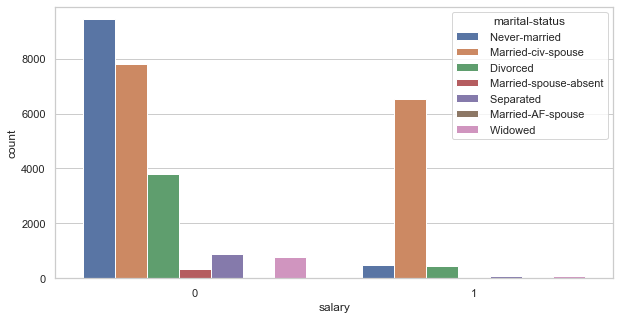

In [198]:
plt.figure(figsize=(10,5))
sns.countplot(x = 'salary',
            hue = 'marital-status',
            data = df)
plt.show()

# marred-civ-spouse have more chance of earning more then 50K pa.

In [199]:
df['marital-status'].unique()

array([' Never-married', ' Married-civ-spouse', ' Divorced',
       ' Married-spouse-absent', ' Separated', ' Married-AF-spouse',
       ' Widowed'], dtype=object)

In [200]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,country,salary
0,39,State-gov,77516,13.0,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,13.0,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,8.0,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,6.0,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,13.0,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


In [202]:
# Convert values of marital status to only single and married
df.replace(df['marital-status'].unique(),['single','married','single','single','single','married','single'],inplace=True)

In [203]:
df1 = df.copy()

In [204]:
df = pd.get_dummies(df,columns=['marital-status'],drop_first=True)

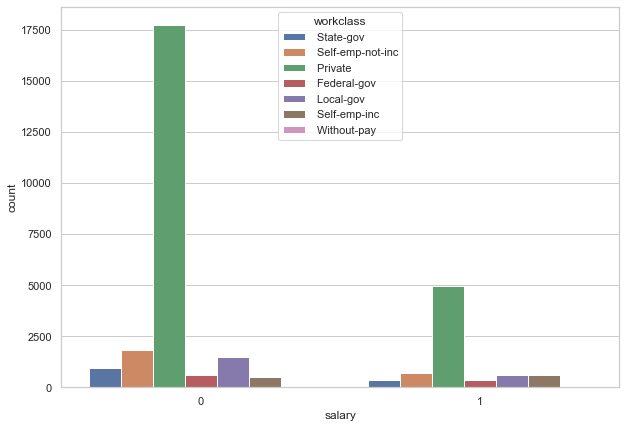

In [205]:
plt.figure(figsize=(10,7))
sns.countplot( x='salary',
    hue='workclass',
    data=df)
plt.show()

In [206]:
df['workclass'].unique()

array([' State-gov', ' Self-emp-not-inc', ' Private', ' Federal-gov',
       ' Local-gov', ' Self-emp-inc', ' Without-pay'], dtype=object)

In [207]:
df1['workclass'].value_counts(normalize=True)*100

 Private             73.885019
 Self-emp-not-inc     8.272023
 Local-gov            6.813595
 State-gov            4.225536
 Self-emp-inc         3.633049
 Federal-gov          3.125203
 Without-pay          0.045576
Name: workclass, dtype: float64

In [208]:
df = pd.get_dummies(df,columns=['workclass'],drop_first=True)

In [209]:
df['occupation'].unique()

array([' Adm-clerical', ' Exec-managerial', ' Handlers-cleaners',
       ' Prof-specialty', ' Other-service', ' Sales', ' Craft-repair',
       ' Transport-moving', ' Farming-fishing', ' Machine-op-inspct',
       ' Tech-support', ' Protective-serv', ' Armed-Forces',
       ' Priv-house-serv'], dtype=object)

In [210]:
df['occupation'].value_counts(normalize=True)*100

 Prof-specialty       13.477440
 Craft-repair         13.343968
 Exec-managerial      13.236539
 Adm-clerical         12.272934
 Sales                11.882284
 Other-service        10.726610
 Machine-op-inspct     6.517351
 Transport-moving      5.198906
 Handlers-cleaners     4.459926
 Farming-fishing       3.235888
 Tech-support          3.021030
 Protective-serv       2.112768
 Priv-house-serv       0.485058
 Armed-Forces          0.029299
Name: occupation, dtype: float64

In [211]:
# Occupation count less then 2%
df['occupation'].value_counts()[df['occupation'].value_counts(normalize=True)*100 < 2].index

Index([' Priv-house-serv', ' Armed-Forces'], dtype='object')

In [212]:
# naming less frequent occupation as others (having value counts less than 2% of total values)
percentage_threshold = 2
arr_others = df['occupation'].value_counts()[df['occupation'].value_counts(normalize=True)*100 < percentage_threshold].index
df['occupation'].replace(to_replace=arr_others, value = ['others']*len(arr_others), inplace=True)

In [213]:
df['occupation'].value_counts()

 Prof-specialty       4140
 Craft-repair         4099
 Exec-managerial      4066
 Adm-clerical         3770
 Sales                3650
 Other-service        3295
 Machine-op-inspct    2002
 Transport-moving     1597
 Handlers-cleaners    1370
 Farming-fishing       994
 Tech-support          928
 Protective-serv       649
others                 158
Name: occupation, dtype: int64

In [214]:
df = pd.get_dummies(df,columns=['occupation'],drop_first=True)

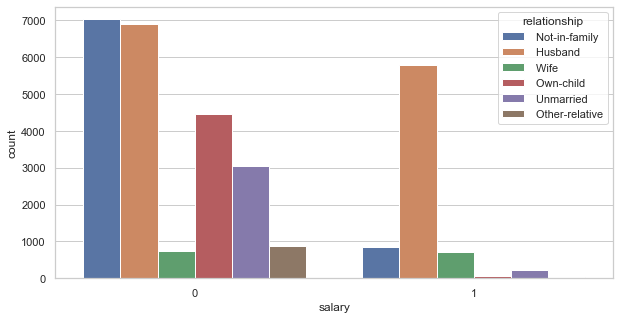

In [215]:
plt.figure(figsize=(10,5))
sns.countplot(x='salary',
             hue = 'relationship',
             data = df)
plt.show()

In [216]:
df['relationship'].unique()

array([' Not-in-family', ' Husband', ' Wife', ' Own-child', ' Unmarried',
       ' Other-relative'], dtype=object)

In [217]:
df['relationship'].value_counts()

 Husband           12704
 Not-in-family      7865
 Own-child          4525
 Unmarried          3271
 Wife               1435
 Other-relative      918
Name: relationship, dtype: int64

In [218]:
df = pd.get_dummies(df,columns=['relationship'],drop_first=True)

In [219]:
df.columns

Index(['age', 'fnlwgt', 'education', 'education-num', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'country', 'salary',
       'marital-status_single', 'workclass_ Local-gov', 'workclass_ Private',
       'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc',
       'workclass_ State-gov', 'workclass_ Without-pay',
       'occupation_ Craft-repair', 'occupation_ Exec-managerial',
       'occupation_ Farming-fishing', 'occupation_ Handlers-cleaners',
       'occupation_ Machine-op-inspct', 'occupation_ Other-service',
       'occupation_ Prof-specialty', 'occupation_ Protective-serv',
       'occupation_ Sales', 'occupation_ Tech-support',
       'occupation_ Transport-moving', 'occupation_others',
       'relationship_ Not-in-family', 'relationship_ Other-relative',
       'relationship_ Own-child', 'relationship_ Unmarried',
       'relationship_ Wife'],
      dtype='object')

In [220]:
df = pd.get_dummies(df,columns=['sex'],drop_first=True)

In [221]:
df['country'].value_counts(normalize=True)*100

 United-States                 91.347093
 Mexico                         1.985806
 Philippines                    0.612019
 Germany                        0.416694
 Puerto-Rico                    0.354841
 Canada                         0.348330
 El-Salvador                    0.325542
 India                          0.325542
 Cuba                           0.299499
 England                        0.279966
 Jamaica                        0.260434
 South                          0.231135
 Italy                          0.221369
 China                          0.221369
 Dominican-Republic             0.218113
 Vietnam                        0.208347
 Guatemala                      0.205091
 Japan                          0.192070
 Poland                         0.182304
 Columbia                       0.182304
 Haiti                          0.136728
 Iran                           0.136728
 Taiwan                         0.136728
 Portugal                       0.110684
 Nicaragua      

In [222]:
# naming less frequent countries as others (having value counts less than 0.3% of total values)
percentage_threshold = 0.3
arr_others = df['country'].value_counts()[df['country'].value_counts(normalize=True)*100 < percentage_threshold].index
df['country'].replace(to_replace=arr_others, value = ['others']*len(arr_others), inplace=True)

In [223]:
df['country'].value_counts()

 United-States    28060
others             1316
 Mexico             610
 Philippines        188
 Germany            128
 Puerto-Rico        109
 Canada             107
 El-Salvador        100
 India              100
Name: country, dtype: int64

In [224]:
df = pd.get_dummies(df,columns=['country'],drop_first=True)

In [225]:
df.columns

Index(['age', 'fnlwgt', 'education', 'education-num', 'race', 'capital-gain',
       'capital-loss', 'hours-per-week', 'salary', 'marital-status_single',
       'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc',
       'workclass_ Self-emp-not-inc', 'workclass_ State-gov',
       'workclass_ Without-pay', 'occupation_ Craft-repair',
       'occupation_ Exec-managerial', 'occupation_ Farming-fishing',
       'occupation_ Handlers-cleaners', 'occupation_ Machine-op-inspct',
       'occupation_ Other-service', 'occupation_ Prof-specialty',
       'occupation_ Protective-serv', 'occupation_ Sales',
       'occupation_ Tech-support', 'occupation_ Transport-moving',
       'occupation_others', 'relationship_ Not-in-family',
       'relationship_ Other-relative', 'relationship_ Own-child',
       'relationship_ Unmarried', 'relationship_ Wife', 'sex_ Male',
       'country_ El-Salvador', 'country_ Germany', 'country_ India',
       'country_ Mexico', 'country_ Philippine

In [226]:
df[['capital-gain','capital-loss']]

,capital-gain,capital-loss
0,2174,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
32556,0,0
32557,0,0
32558,0,0
32559,0,0


In [227]:
df['capital_gain_or_loss'] = df['capital-gain']-df['capital-loss']

In [228]:
df['capital_gain_or_loss']

0         2174
1            0
2            0
3            0
4            0
         ...  
32556        0
32557        0
32558        0
32559        0
32560    15024
Name: capital_gain_or_loss, Length: 30718, dtype: int64

In [229]:
df['race'].value_counts(normalize=True)*100

 White                 85.620809
 Black                  9.470018
 Asian-Pac-Islander     3.170779
 Amer-Indian-Eskimo     0.931050
 Other                  0.807344
Name: race, dtype: float64

In [230]:
# naming less frequent countries as others (having value counts less than 1% of total values)
percentage_threshold = 1
arr_others = df['race'].value_counts()[df['race'].value_counts(normalize=True)*100 < percentage_threshold].index
df['race'].replace(to_replace=arr_others, value = ['others']*len(arr_others), inplace=True)

In [231]:
df['race'].value_counts()

 White                 26301
 Black                  2909
 Asian-Pac-Islander      974
others                   534
Name: race, dtype: int64

In [232]:
pd.set_option('display.max_columns',None)

In [233]:
df.head()

,age,fnlwgt,education,education-num,race,capital-gain,capital-loss,hours-per-week,salary,marital-status_single,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,occupation_others,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Male,country_ El-Salvador,country_ Germany,country_ India,country_ Mexico,country_ Philippines,country_ Puerto-Rico,country_ United-States,country_others,capital_gain_or_loss
0,39,77516,13.0,13,White,2174,0,40,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,2174
1,50,83311,13.0,13,White,0,0,13,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
2,38,215646,8.0,9,White,0,0,40,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0
3,53,234721,6.0,7,Black,0,0,40,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
4,28,338409,13.0,13,Black,0,0,40,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0


In [234]:
df.shape

(30718, 43)

In [235]:
df.columns

Index(['age', 'fnlwgt', 'education', 'education-num', 'race', 'capital-gain',
       'capital-loss', 'hours-per-week', 'salary', 'marital-status_single',
       'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc',
       'workclass_ Self-emp-not-inc', 'workclass_ State-gov',
       'workclass_ Without-pay', 'occupation_ Craft-repair',
       'occupation_ Exec-managerial', 'occupation_ Farming-fishing',
       'occupation_ Handlers-cleaners', 'occupation_ Machine-op-inspct',
       'occupation_ Other-service', 'occupation_ Prof-specialty',
       'occupation_ Protective-serv', 'occupation_ Sales',
       'occupation_ Tech-support', 'occupation_ Transport-moving',
       'occupation_others', 'relationship_ Not-in-family',
       'relationship_ Other-relative', 'relationship_ Own-child',
       'relationship_ Unmarried', 'relationship_ Wife', 'sex_ Male',
       'country_ El-Salvador', 'country_ Germany', 'country_ India',
       'country_ Mexico', 'country_ Philippine

<AxesSubplot:>

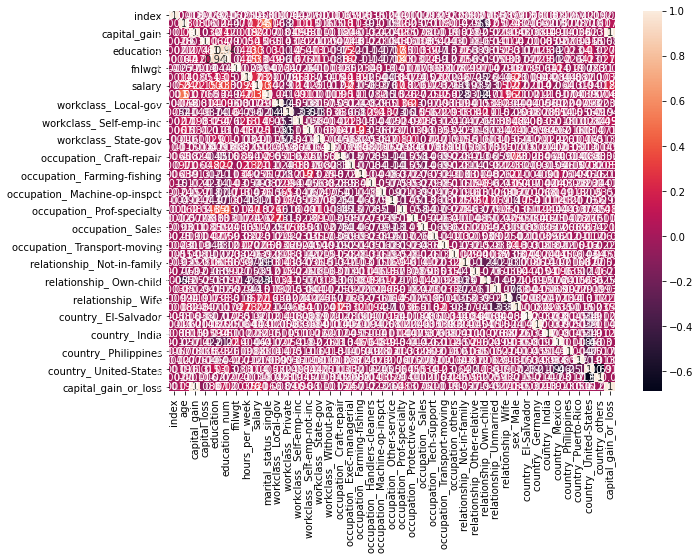

In [66]:
plt.figure(figsize=(10,7))
sns.heatmap(df.corr(),annot=True)

# Outlier detection

In [67]:
df.describe()

,index,age,capital_gain,capital_loss,education,education_num,fnlwgt,hours_per_week,salary,marital_status_single,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,occupation_others,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Male,country_ El-Salvador,country_ Germany,country_ India,country_ Mexico,country_ Philippines,country_ Puerto-Rico,country_ United-States,country_others,capital_gain_or_loss
count,30718.000000,30718.000000,30718.000000,30718.000000,30718.000000,30718.000000,3.071800e+04,30718.000000,30718.000000,30718.000000,30718.000000,30718.000000,30718.000000,30718.000000,30718.000000,30718.000000,30718.000000,30718.000000,30718.000000,30718.000000,30718.000000,30718.000000,30718.000000,30718.000000,30718.000000,30718.000000,30718.000000,30718.000000,30718.000000,30718.000000,30718.000000,30718.000000,30718.000000,30718.000000,30718.000000,30718.000000,30718.000000,30718.000000,30718.000000,30718.000000,30718.000000,30718.000000,30718.000000
mean,16287.216583,38.443584,1106.037079,88.910216,9.569275,10.130314,1.898455e+05,40.949313,0.249040,0.646103,0.068136,0.738850,0.036330,0.082720,0.042255,0.000456,0.133440,0.132365,0.032359,0.044599,0.065174,0.107266,0.134774,0.021128,0.118823,0.030210,0.051989,0.005144,0.256039,0.029885,0.147308,0.106485,0.046715,0.676737,0.003255,0.004167,0.003255,0.019858,0.006120,0.003548,0.913471,0.042841,1017.126864
std,9384.605925,13.118227,7497.863364,405.657203,2.835716,2.562469,1.054583e+05,11.985382,0.432464,0.478185,0.251983,0.439269,0.187114,0.275463,0.201174,0.021344,0.340055,0.338893,0.176954,0.206426,0.246836,0.309456,0.341488,0.143812,0.323585,0.171168,0.222009,0.071535,0.436451,0.170272,0.354418,0.308462,0.211032,0.467730,0.056964,0.064418,0.056964,0.139515,0.077993,0.059464,0.281148,0.202503,7521.914330
min,1.000000,17.000000,0.000000,0.000000,0.000000,1.000000,1.376900e+04,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4356.000000
25%,8173.250000,28.000000,0.000000,0.000000,8.000000,9.000000,1.178285e+05,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,16278.500000,37.000000,0.000000,0.000000,10.000000,10.000000,1.785170e+05,40.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,24409.750000,47.000000,0.000000,0.000000,12.000000,13.000000,2.373170e+05,45.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,32561.000000,90.000000,99999.000000,4356.000000,15.000000,16.000000,1.484705e+06,99.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000

In [68]:
#age,education,hours_per_week,capital_gain_or_loss

In [236]:
df['age'].min()

17

In [237]:
df['hours-per-week'].max()

99

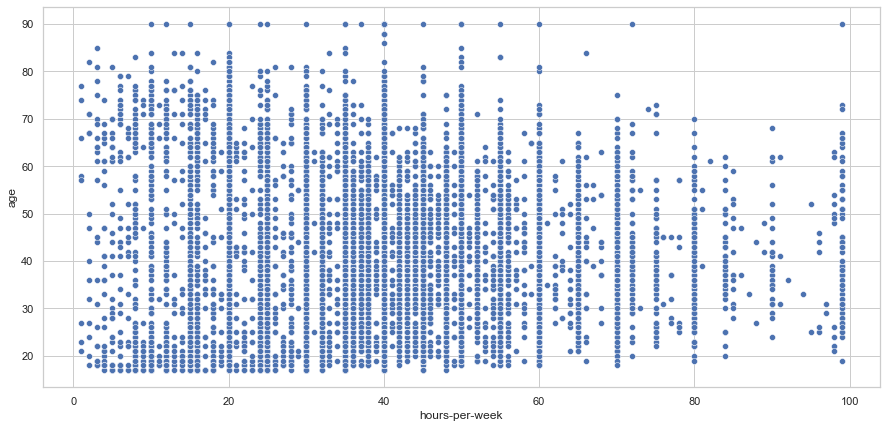

In [239]:
plt.figure(figsize=(15,7))
sns.set(style='whitegrid')
sns.scatterplot(x='hours-per-week',y='age',data=df1)
plt.show()

its not possible to work after age 90 and more then 60-70 hours per week is outlier

<AxesSubplot:xlabel='age'>

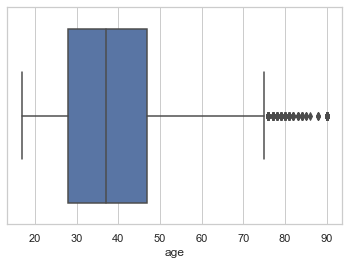

In [240]:
sns.boxplot(x='age', data=df)

In [241]:
max_threshold = df['age'].quantile(0.99)

In [242]:
# min_threshold = df1['age'].quantile(0.01)

In [243]:
df = df[df['age']<max_threshold]

<AxesSubplot:xlabel='age'>

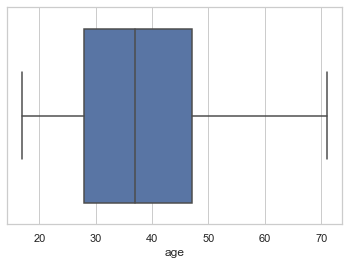

In [244]:
sns.boxplot(x='age', data=df)

In [245]:
df['education'].max()

15.0

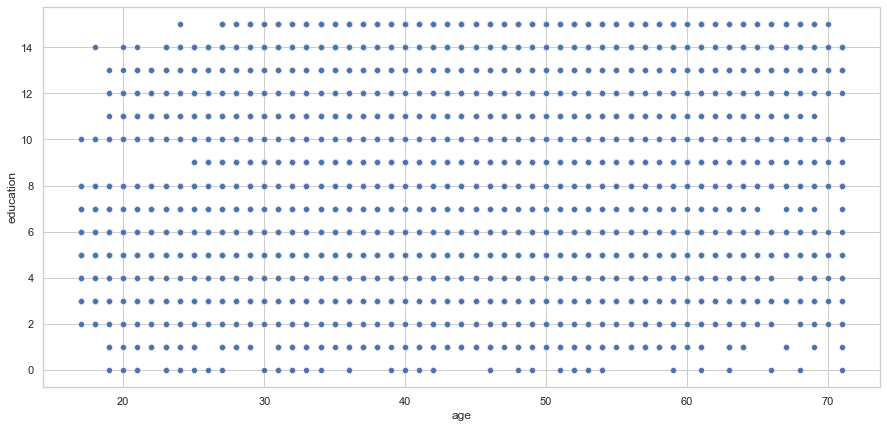

In [127]:
plt.figure(figsize=(15,7))
sns.set(style='whitegrid')
sns.scatterplot(x='age',y='education',data=df)
plt.show()

It is imposible to educate as masters or phd below 20

In [246]:
index = df[(df['age'] <= 18) & (df['education'] >= 13)].index
index

Int64Index([12183], dtype='int64')

In [247]:
df.drop(index=index,inplace=True )

<AxesSubplot:xlabel='education'>

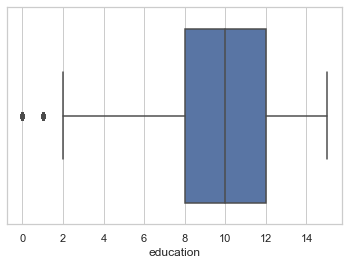

In [130]:
sns.boxplot(x='education', data=df)

In [131]:
df.head()

,index,age,capital_gain,capital_loss,education,education_num,fnlwgt,hours_per_week,race,salary,marital_status_single,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,occupation_others,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Male,country_ El-Salvador,country_ Germany,country_ India,country_ Mexico,country_ Philippines,country_ Puerto-Rico,country_ United-States,country_others,capital_gain_or_loss
0,4317,65,0,0,10.0,10,225473,35,White,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,25269,22,0,0,11.0,12,188274,40,White,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0
3,14340,43,0,0,10.0,10,101709,40,Asian-Pac-Islander,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0
4,18417,24,0,0,10.0,10,32921,50,White,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0
5,1584,39,10520,0,8.0,9,128715,40,White,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,10520


C:\Users\hp\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


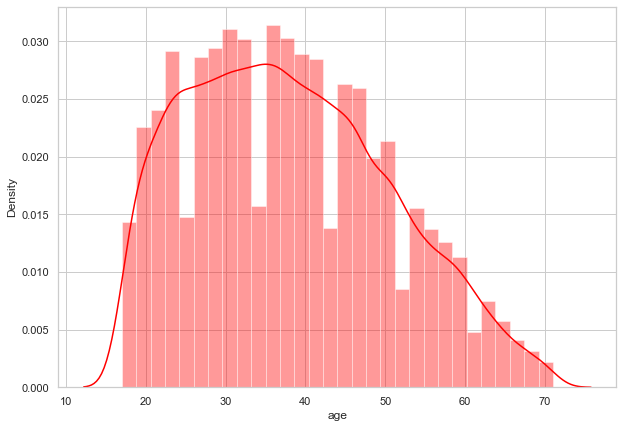

In [132]:
plt.figure(figsize=(10,7))
sns.set_style('whitegrid')
sns.distplot(df['age'], kde = True, color ='red', bins = 30)
plt.show()

C:\Users\hp\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='education', ylabel='Density'>

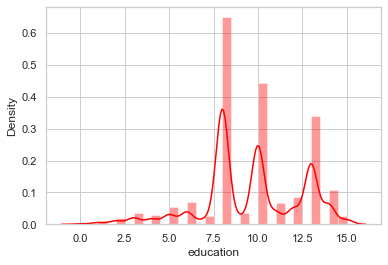

In [133]:
sns.distplot(df['education'], kde = True, color ='red', bins = 30)

C:\Users\hp\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='hours_per_week', ylabel='Density'>

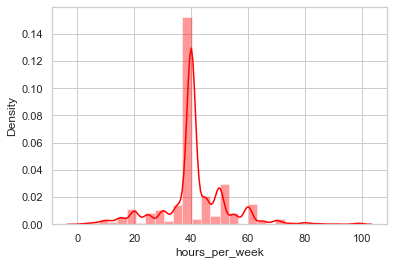

In [134]:
sns.distplot(df['hours_per_week'], kde = True, color ='red', bins = 30)

C:\Users\hp\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='capital_gain_or_loss', ylabel='Density'>

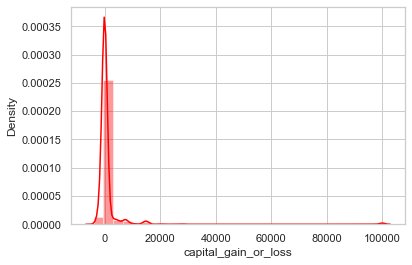

In [135]:
sns.distplot(df['capital_gain_or_loss'], kde = True, color ='red', bins = 30)

# Feature Selection

In [76]:
# plt.figure(figsize=(10,7))
# sns.heatmap(df.corr(),annot=True)

In [77]:
df.columns

Index(['index', 'age', 'capital_gain', 'capital_loss', 'education',
       'education_num', 'fnlwgt', 'hours_per_week', 'race', 'salary',
       'marital_status_single', 'workclass_ Local-gov', 'workclass_ Private',
       'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc',
       'workclass_ State-gov', 'workclass_ Without-pay',
       'occupation_ Craft-repair', 'occupation_ Exec-managerial',
       'occupation_ Farming-fishing', 'occupation_ Handlers-cleaners',
       'occupation_ Machine-op-inspct', 'occupation_ Other-service',
       'occupation_ Prof-specialty', 'occupation_ Protective-serv',
       'occupation_ Sales', 'occupation_ Tech-support',
       'occupation_ Transport-moving', 'occupation_others',
       'relationship_ Not-in-family', 'relationship_ Other-relative',
       'relationship_ Own-child', 'relationship_ Unmarried',
       'relationship_ Wife', 'sex_ Male', 'country_ El-Salvador',
       'country_ Germany', 'country_ India', 'country_ Mexico',
       'cou

In [248]:
df.drop(columns=['capital-gain','capital-loss','education-num','fnlwgt','race',
                'relationship_ Not-in-family', 'relationship_ Other-relative',
                'relationship_ Own-child', 'relationship_ Unmarried',
                'relationship_ Wife'] ,axis=1, inplace=True)

In [249]:
df.head()

,age,education,hours-per-week,salary,marital-status_single,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,occupation_others,sex_ Male,country_ El-Salvador,country_ Germany,country_ India,country_ Mexico,country_ Philippines,country_ Puerto-Rico,country_ United-States,country_others,capital_gain_or_loss
0,39,13.0,40,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,2174
1,50,13.0,13,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
2,38,8.0,40,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
3,53,6.0,40,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
4,28,13.0,40,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [300]:
df1 = df.copy()

In [301]:
# df1 = pd.read_csv('D:\\Downloads\\ML projects\\adult income prediction Ineuron_internship-main\\df1_extra.csv')

In [302]:
x = df1.drop(columns=['salary'] ,axis=1)
y = df1['salary']

In [303]:
x

,age,education,hours-per-week,marital-status_single,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,occupation_others,sex_ Male,country_ El-Salvador,country_ Germany,country_ India,country_ Mexico,country_ Philippines,country_ Puerto-Rico,country_ United-States,country_others,capital_gain_or_loss
0,39,13.0,40,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,2174
1,50,13.0,13,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
2,38,8.0,40,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
3,53,6.0,40,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
4,28,13.0,40,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,11.0,38,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
32557,40,8.0,40,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
32558,58,8.0,40,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
32559,22,8.0,20,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0


In [304]:
x.columns

Index(['age', 'education', 'hours-per-week', 'marital-status_single',
       'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc',
       'workclass_ Self-emp-not-inc', 'workclass_ State-gov',
       'workclass_ Without-pay', 'occupation_ Craft-repair',
       'occupation_ Exec-managerial', 'occupation_ Farming-fishing',
       'occupation_ Handlers-cleaners', 'occupation_ Machine-op-inspct',
       'occupation_ Other-service', 'occupation_ Prof-specialty',
       'occupation_ Protective-serv', 'occupation_ Sales',
       'occupation_ Tech-support', 'occupation_ Transport-moving',
       'occupation_others', 'sex_ Male', 'country_ El-Salvador',
       'country_ Germany', 'country_ India', 'country_ Mexico',
       'country_ Philippines', 'country_ Puerto-Rico',
       'country_ United-States', 'country_others', 'capital_gain_or_loss'],
      dtype='object')

In [306]:
x.rename(columns = {
    'workclass_ Local-gov' : 'local_gov' ,
    'hours-per-week' : 'hours_per_week',
    'marital-status_single' : 'marital_status_single',
    'workclass_ Private' : 'private' ,
    'workclass_ Self-emp-inc' : 'self_emp_inc' ,    
    'workclass_ Self-emp-not-inc' : 'self_emp_not_inc' ,
    'workclass_ State-gov' : 'state_gov' ,
    'workclass_ Without-pay' : 'without_pay' ,
    'occupation_ Craft-repair' : 'craft_repair' ,
    'occupation_ Exec-managerial' : 'exec_managerial' ,
    'occupation_ Farming-fishing' : 'farming_fishing' ,
    'occupation_ Handlers-cleaners' : 'handlers_cleaners' ,
    'occupation_ Machine-op-inspct' : 'machine_op_inspct' ,
    'occupation_ Other-service' : 'other' ,
    'occupation_ Prof-specialty' : 'prof_specialty' ,
    'occupation_ Protective-serv' : 'protective_serv' ,
    'occupation_ Sales' : 'sales' ,
    'occupation_ Tech-support' : 'tech_support' ,
    'occupation_ Transport-moving' : 'transport_moving' ,
    'occupation_others' : 'others' ,
    'sex_ Male' : 'male' ,
    'country_ El-Salvador' : 'el_salvador' ,
    'country_ Germany' : 'germany' ,
    'country_ India' : 'india' ,
    'country_ Mexico' : 'mexico' ,
    'country_ Philippines' : 'philippines' , 
    'country_ Puerto-Rico' : 'puerto_rico' ,
    'country_ United-States' : 'united_states' 
},inplace=True)

In [307]:
x.columns

Index(['age', 'education', 'hours_per_week', 'marital_status_single',
       'local_gov', 'private', 'self_emp_inc', 'self_emp_not_inc', 'state_gov',
       'without_pay', 'craft_repair', 'exec_managerial', 'farming_fishing',
       'handlers_cleaners', 'machine_op_inspct', 'other', 'prof_specialty',
       'protective_serv', 'sales', 'tech_support', 'transport_moving',
       'others', 'male', 'el_salvador', 'germany', 'india', 'mexico',
       'philippines', 'puerto_rico', 'united_states', 'country_others',
       'capital_gain_or_loss'],
      dtype='object')

In [82]:
# df1.to_csv('dff.csv')

# Model Building

In [72]:
pip install xgboost

In [73]:
pip install imblearn

In [287]:
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from sklearn.model_selection import cross_val_score, KFold , StratifiedKFold
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.combine import SMOTETomek 
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

In [102]:
df1.head()

,age,education,hours-per-week,salary,marital-status_ Married-AF-spouse,marital-status_ Married-civ-spouse,marital-status_ Married-spouse-absent,marital-status_ Never-married,marital-status_ Separated,marital-status_ Widowed,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,occupation_others,sex_ Male,country_ El-Salvador,country_ Germany,country_ India,country_ Mexico,country_ Philippines,country_ Puerto-Rico,country_ United-States,country_others,capital_gain_or_loss
0,39,13.0,40,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,2174
1,50,13.0,13,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
2,38,8.0,40,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
3,53,6.0,40,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
4,28,13.0,40,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [308]:
ct = ColumnTransformer([
                           ('std_scaling', StandardScaler(),['age','hours_per_week']),
                           ('min_max_scaling',MinMaxScaler(),['education','capital_gain_or_loss'])
], remainder='passthrough')

In [ ]:
# comparing different classification models using sklearn pipeline
models = [LogisticRegression(), SVC(), RandomForestClassifier(), XGBClassifier(),\
          DecisionTreeClassifier(), KNeighborsClassifier()]

model_labels = ['LogisticReg', 'SVC', 'RandomForest', 'Xgboost','DecisionTree','KNN']
accuracy_mean_scores = []

for model in models:

    pipeline = Pipeline([
                        ('columnTransformer', ct),
                        ('resample', SMOTETomek()),
                        ('model', model)
    ])
    accuracy_mean = cross_val_score(pipeline, x, y, cv=StratifiedKFold(n_splits=10), scoring='accuracy',n_jobs=-1).mean()
    accuracy_mean_scores.append(accuracy_mean)

In [ ]:
# accuracy_mean_scores = [0.7729830288323335,
#  0.7702842095982424,
#  0.8141928681799758,
#  0.8104738032524732,
#  0.7968466875971164,
#  0.7501397024115508]

# HyperParameter Tuning

In [189]:
from sklearn.model_selection import RandomizedSearchCV

In [190]:
# for model_rf
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 20, num = 20)] # number of trees in the random forest
max_features = ['auto', 'sqrt'] # number of features in consideration at every split
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree
min_samples_split = [2, 6, 10] # minimum sample number to split a node
min_samples_leaf = [1, 3, 4] # minimum sample number that can be stored in a leaf node
bootstrap = [True, False] # method used to sample data points

params = {'model__n_estimators': n_estimators,

'model__max_features': max_features,

'model__max_depth': max_depth,

'model__min_samples_split': min_samples_split,

'model__min_samples_leaf': min_samples_leaf,

'model__bootstrap': bootstrap}

In [183]:
# params = {'bootstrap': [True, False],
#  'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
#  'max_features': ['auto', 'sqrt'],
#  'min_samples_leaf': [1, 2, 4],
#  'min_samples_split': [2, 5, 10],
#  'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [92]:
pipeline = Pipeline([
                      ('columnTransformer', ct),
                      ('model', RandomForestClassifier())
])

In [93]:
random_search = RandomizedSearchCV(pipeline,param_distributions=params,scoring='accuracy',n_jobs=-1,cv=KFold(n_splits=5))

NameError: name 'RandomizedSearchCV' is not defined

In [186]:
random_search.fit(x, y)

ValueError: Invalid parameter bootstrap for estimator Pipeline(steps=[('columnTransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('std_scaling',
                                                  StandardScaler(),
                                                  ['age', 'hours_per_week']),
                                                 ('min_max_scaling',
                                                  MinMaxScaler(),
                                                  ['education',
                                                   'capital_gain_or_loss'])])),
                ('model', RandomForestClassifier())]). Check the list of available parameters with `estimator.get_params().keys()`.

In [ ]:
random_search.best_params_

# {'model__bootstrap': True,
#  'model__max_depth': 50,
#  'model__max_features': 'sqrt',
#  'model__min_samples_leaf': 4,
#  'model__min_samples_split': 10,
#  'model__n_estimators': 6}

In [ ]:
random_search.best_score_

# 0.8442444845678615

In [309]:
# Creating pipeline with new parameters after optained from gridsearchcv
pipeline = Pipeline([
                      ('columnTransformer', ct),
                      ('resample', SMOTETomek()),
                      ('model', RandomForestClassifier(bootstrap = True,
                                                      max_depth = 50,
                                                      max_features = 'sqrt',
                                                      min_samples_leaf = 4,
                                                      min_samples_split = 10,
                                                      n_estimators = 6))
])

In [ ]:
accuracy_scores = cross_val_score(pipeline, x, y, scoring='accuracy', cv=StratifiedKFold(n_splits=10), n_jobs=-1)

# [0.81375452, 0.81665569, 0.80348914, 0.80184332, 0.80447663,
#        0.80315997, 0.81764319, 0.81336406, 0.80348914, 0.80217248]

In [ ]:
f1_scores = cross_val_score(pipeline, x, y, scoring='f1', cv=StratifiedKFold(n_splits=10), n_jobs=-1)

# [0.66705607, 0.66283084, 0.6557377 , 0.6570771 , 0.66318235,
#        0.64336493, 0.65585586, 0.65848214, 0.66035503, 0.65645256]

# Model Testing

In [310]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, matthews_corrcoef, balanced_accuracy_score

In [311]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0,stratify=y)

In [312]:
x_train

,age,education,hours_per_week,marital_status_single,local_gov,private,self_emp_inc,self_emp_not_inc,state_gov,without_pay,craft_repair,exec_managerial,farming_fishing,handlers_cleaners,machine_op_inspct,other,prof_specialty,protective_serv,sales,tech_support,transport_moving,others,male,el_salvador,germany,india,mexico,philippines,puerto_rico,united_states,country_others,capital_gain_or_loss
16694,55,8.0,40,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
5415,23,8.0,40,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1819,43,13.0,50,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
23615,48,1.0,40,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
13355,20,10.0,40,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19718,33,13.0,50,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
7432,46,10.0,45,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,-1887
10789,34,10.0,40,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,2174
8651,49,10.0,65,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0


In [313]:
y_train

16694    1
5415     0
1819     1
23615    0
13355    0
        ..
19718    0
7432     1
10789    0
8651     0
32204    0
Name: salary, Length: 24304, dtype: int64

In [314]:
x_test

,age,education,hours_per_week,marital_status_single,local_gov,private,self_emp_inc,self_emp_not_inc,state_gov,without_pay,craft_repair,exec_managerial,farming_fishing,handlers_cleaners,machine_op_inspct,other,prof_specialty,protective_serv,sales,tech_support,transport_moving,others,male,el_salvador,germany,india,mexico,philippines,puerto_rico,united_states,country_others,capital_gain_or_loss
20255,49,13.0,50,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
20769,30,8.0,40,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
30400,50,10.0,70,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0
13826,26,13.0,50,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
11073,47,13.0,40,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23651,57,13.0,40,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0
15240,44,10.0,40,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
28070,36,13.0,35,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
11129,27,5.0,40,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0


In [315]:
y

0        0
1        0
2        0
3        0
4        0
        ..
32556    0
32557    1
32558    0
32559    0
32560    1
Name: salary, Length: 30381, dtype: int64

In [316]:
x_train.columns

Index(['age', 'education', 'hours_per_week', 'marital_status_single',
       'local_gov', 'private', 'self_emp_inc', 'self_emp_not_inc', 'state_gov',
       'without_pay', 'craft_repair', 'exec_managerial', 'farming_fishing',
       'handlers_cleaners', 'machine_op_inspct', 'other', 'prof_specialty',
       'protective_serv', 'sales', 'tech_support', 'transport_moving',
       'others', 'male', 'el_salvador', 'germany', 'india', 'mexico',
       'philippines', 'puerto_rico', 'united_states', 'country_others',
       'capital_gain_or_loss'],
      dtype='object')

In [317]:
y_train

16694    1
5415     0
1819     1
23615    0
13355    0
        ..
19718    0
7432     1
10789    0
8651     0
32204    0
Name: salary, Length: 24304, dtype: int64

In [318]:
os.getcwd()

'D:\\Downloads\\ML projects\\adult income prediction Ineuron_internship-main - Copy'

In [319]:
pipeline.fit(x_train, y_train)

Pipeline(steps=[('columnTransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('std_scaling',
                                                  StandardScaler(),
                                                  ['age', 'hours_per_week']),
                                                 ('min_max_scaling',
                                                  MinMaxScaler(),
                                                  ['education',
                                                   'capital_gain_or_loss'])])),
                ('resample', SMOTETomek()),
                ('model',
                 RandomForestClassifier(max_depth=50, max_features='sqrt',
                                        min_samples_leaf=4,
                                        min_samples_split=10,
                                        n_estimators=6))])

In [320]:
import joblib
joblib.dump(pipeline, 'pipeline.joblib')

['pipeline.joblib']

In [321]:
x_train.columns

Index(['age', 'education', 'hours_per_week', 'marital_status_single',
       'local_gov', 'private', 'self_emp_inc', 'self_emp_not_inc', 'state_gov',
       'without_pay', 'craft_repair', 'exec_managerial', 'farming_fishing',
       'handlers_cleaners', 'machine_op_inspct', 'other', 'prof_specialty',
       'protective_serv', 'sales', 'tech_support', 'transport_moving',
       'others', 'male', 'el_salvador', 'germany', 'india', 'mexico',
       'philippines', 'puerto_rico', 'united_states', 'country_others',
       'capital_gain_or_loss'],
      dtype='object')

In [168]:
type(x_test)

pandas.core.frame.DataFrame

In [130]:
x.columns

Index(['age', 'education', 'hours-per-week',
       'marital-status_ Married-AF-spouse',
       'marital-status_ Married-civ-spouse',
       'marital-status_ Married-spouse-absent',
       'marital-status_ Never-married', 'marital-status_ Separated',
       'marital-status_ Widowed', 'local_gov', 'private', 'self_emp_inc',
       'self_emp_not_inc', 'state_gov', 'without_pay', 'craft_repair',
       'exec_managerial', 'farming_fishing', 'handlers_cleaners',
       'machine_op_inspct', 'other', 'prof_specialty', 'protective_serv',
       'sales', 'tech_support', 'transport_moving', 'others', 'male',
       'el_salvador', 'germany', 'india', 'mexico', 'philippines',
       'puerto_rico', 'united_states', 'country_others',
       'capital_gain_or_loss'],
      dtype='object')

In [163]:
y_pred = pipeline.predict(x_test)
y_pred

array([1, 0, 1, ..., 0, 0, 0], dtype=int64)

In [144]:
x_test.iloc[0].values.tolist()

[49.0,
 13.0,
 50.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0]

In [166]:
pipeline.predict([[49.0,
 13.0,
 50.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0]])

ValueError: Specifying the columns using strings is only supported for pandas DataFrames

In [ ]:
sns.heatmap(confusion_matrix(y_pred=y_pred, y_true=y_test),annot=True)

In [ ]:
pd.DataFrame(confusion_matrix(y_pred=y_pred, y_true=y_test))

In [ ]:
print('recall :', recall_score(y_test, y_pred))
print('precision :', precision_score(y_test, y_pred))
print('F1 :', f1_score(y_test, y_pred))
print('accuracy :', accuracy_score(y_test, y_pred))
print('matthews_corrcoef :', matthews_corrcoef(y_test, y_pred))
print('balanced_accuracy_score :', balanced_accuracy_score(y_test, y_pred))

# recall : 0.7397891963109354
# precision : 0.5821669258683255
# F1 : 0.6515810850014504
# accuracy : 0.8023695902583512
# matthews_corrcoef : 0.5235890244856193
# balanced_accuracy_score : 0.7814980199584947

In [137]:
import pickle
import os

In [185]:
print(os.getcwd())

D:\Downloads\ML projects\adult income prediction Ineuron_internship-main - Copy



So, as we can see we are getting some good with our Randomforest model after hyperparameter tuning using RandomizedSearchCV. Now, using this model in production

In [183]:
data_pipeline = joblib.load(open('D://Downloads//ML projects//adult income prediction Ineuron_internship-main - Copy//pipeline.joblib','rb'))


In [184]:
type(data_pipeline)

imblearn.pipeline.Pipeline

# Scaling

In [381]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()

In [382]:
# from sklearn.preprocessing import MinMaxScaler
# mms = MinMaxScaler()

In [383]:
scaled1 = scaler.fit_transform(df1[['age','hours_per_week']])

In [384]:
scaled2 = mms.fit_transform(df1[['capital_gain_or_loss','education']]) 

In [385]:
scaled1 = pd.DataFrame(data=scaled1,columns=['age','hours_per_week'])

In [386]:
scaled2 = pd.DataFrame(data=scaled2,columns=['capital_gain_or_loss','education'])

In [387]:
df1_scaled = pd.concat([scaled1, scaled2] ,axis = 1)

In [400]:
df1_scaled

,age,hours_per_week,capital_gain_or_loss,education
0,0.558171,2.024874,0.037536,0.933333
1,0.159064,-1.615380,0.037536,0.533333
2,-1.437360,-2.461950,0.058480,0.666667
3,1.436204,2.024874,0.037536,0.400000
4,0.877455,-0.091553,0.182138,0.866667
...,...,...,...,...
24303,-1.597002,-2.207979,0.037536,0.400000
24304,-0.958432,-0.091553,0.037536,0.533333
24305,-1.517181,-0.091553,0.037536,0.533333
24306,-1.357539,-0.091553,0.037536,0.533333


In [412]:
df1.columns

Index(['Unnamed: 0', 'age', 'education', 'hours_per_week', 'salary',
       'marital_status_single', 'workclass_ Local-gov', 'workclass_ Private',
       'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc',
       'workclass_ State-gov', 'workclass_ Without-pay',
       'occupation_ Craft-repair', 'occupation_ Exec-managerial',
       'occupation_ Farming-fishing', 'occupation_ Handlers-cleaners',
       'occupation_ Machine-op-inspct', 'occupation_ Other-service',
       'occupation_ Prof-specialty', 'occupation_ Protective-serv',
       'occupation_ Sales', 'occupation_ Tech-support',
       'occupation_ Transport-moving', 'occupation_others', 'sex_ Male',
       'country_ Cuba', 'country_ El-Salvador', 'country_ Germany',
       'country_ India', 'country_ Mexico', 'country_ Philippines',
       'country_ Puerto-Rico', 'country_ United-States', 'country_others',
       'capital_gain_or_loss'],
      dtype='object')

In [413]:
df1.drop(columns=['age','hours_per_week','capital_gain_or_loss','education'],inplace=True,axis=1)

In [414]:
df1.shape

(24308, 31)

In [415]:
df1_scaled.shape

(24308, 4)

In [416]:
df1.columns

Index(['Unnamed: 0', 'salary', 'marital_status_single', 'workclass_ Local-gov',
       'workclass_ Private', 'workclass_ Self-emp-inc',
       'workclass_ Self-emp-not-inc', 'workclass_ State-gov',
       'workclass_ Without-pay', 'occupation_ Craft-repair',
       'occupation_ Exec-managerial', 'occupation_ Farming-fishing',
       'occupation_ Handlers-cleaners', 'occupation_ Machine-op-inspct',
       'occupation_ Other-service', 'occupation_ Prof-specialty',
       'occupation_ Protective-serv', 'occupation_ Sales',
       'occupation_ Tech-support', 'occupation_ Transport-moving',
       'occupation_others', 'sex_ Male', 'country_ Cuba',
       'country_ El-Salvador', 'country_ Germany', 'country_ India',
       'country_ Mexico', 'country_ Philippines', 'country_ Puerto-Rico',
       'country_ United-States', 'country_others'],
      dtype='object')

In [417]:
df1_scaled.columns

Index(['age', 'hours_per_week', 'capital_gain_or_loss', 'education'], dtype='object')

In [418]:
df = pd.concat([df1,df1_scaled],axis=1)

In [423]:
df.shape

(24308, 35)

In [424]:
import os
df.to_csv(os.getcwd() + '\\train_dataset_final.csv')

we have df (final training dataset) and x_test,y_test without any single modification 

In [49]:
df = pd.read_csv('D:\\Downloads\\ML projects\\adult income prediction Ineuron_internship-main\\dataset_final.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,salary,marital_status_single,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,...,sex_ Male,country_ Cuba,country_ El-Salvador,country_ Germany,country_ India,country_ Mexico,country_ Philippines,country_ Puerto-Rico,country_ United-States,country_others
0,0,15756,1,1,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1,1,27990,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2,9483,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,3,14680,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,4,18491,1,1,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0


In [52]:
x_train = df.drop(columns=['salary','Unnamed: 0','Unnamed: 0.1'],axis=1)
y_train = df['salary']

In [8]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [8]:
# sns.pairplot(df,hue='salary')

C:\Users\hp\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



Error in callback <function flush_figures at 0x0000000008C4A160> (for post_execute):


KeyboardInterrupt: 

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [16]:
path = model_dt.cost_complexity_pruning_path(x_train,y_train)

In [18]:
ccp_alphas = path.ccp_alphas

In [19]:
model_dt_list = []
for ccp in ccp_alphas:
    model_dt = DecisionTreeClassifier(random_state=0,ccp_alpha=ccp)
    model_dt.fit(x_train,y_train)
    model_dt_list.append(model_dt)
model_dt_list

[DecisionTreeClassifier(random_state=0),
 DecisionTreeClassifier(random_state=0),
 DecisionTreeClassifier(random_state=0),
 DecisionTreeClassifier(random_state=0),
 DecisionTreeClassifier(random_state=0),
 DecisionTreeClassifier(random_state=0),
 DecisionTreeClassifier(ccp_alpha=2.710505431213761e-20, random_state=0),
 DecisionTreeClassifier(ccp_alpha=3.963396667176593e-09, random_state=0),
 DecisionTreeClassifier(ccp_alpha=4.333313690404843e-09, random_state=0),
 DecisionTreeClassifier(ccp_alpha=7.39240247274041e-09, random_state=0),
 DecisionTreeClassifier(ccp_alpha=3.082358101744176e-08, random_state=0),
 DecisionTreeClassifier(ccp_alpha=3.5652236674618004e-08, random_state=0),
 DecisionTreeClassifier(ccp_alpha=4.631000348562925e-08, random_state=0),
 DecisionTreeClassifier(ccp_alpha=5.826097212698403e-08, random_state=0),
 DecisionTreeClassifier(ccp_alpha=7.080223314603375e-08, random_state=0),
 DecisionTreeClassifier(ccp_alpha=7.118965133114509e-08, random_state=0),
 DecisionTreeC

In [20]:
train_scores = []
for i in model_dt_list:
    train_scores.append(i.score(x_train,y_train))
train_scores


[0.7893697548132302,
 0.7893697548132302,
 0.7893697548132302,
 0.7893697548132302,
 0.7893697548132302,
 0.7893697548132302,
 0.7893697548132302,
 0.7893697548132302,
 0.7893697548132302,
 0.7893697548132302,
 0.7893697548132302,
 0.7893697548132302,
 0.7893697548132302,
 0.7893697548132302,
 0.7893697548132302,
 0.7893697548132302,
 0.7893697548132302,
 0.7893697548132302,
 0.7893697548132302,
 0.7893697548132302,
 0.7893697548132302,
 0.7893697548132302,
 0.7893697548132302,
 0.7893697548132302,
 0.7893697548132302,
 0.7893697548132302,
 0.7893697548132302,
 0.7893697548132302,
 0.7893697548132302,
 0.7893697548132302,
 0.7893697548132302,
 0.7893697548132302,
 0.7893697548132302,
 0.7893697548132302,
 0.7893697548132302,
 0.7893697548132302,
 0.7893697548132302,
 0.7893697548132302,
 0.7893697548132302,
 0.7893697548132302,
 0.7893697548132302,
 0.7893697548132302,
 0.7893697548132302,
 0.7893697548132302,
 0.7893697548132302,
 0.7893697548132302,
 0.7893697548132302,
 0.7893697548

In [187]:
test_scores = []
for i in model_dt_list:
    test_scores.append(i.score(x_test,y_test))
test_scores

[0.7549983056590986,
 0.7549983056590986,
 0.7549983056590986,
 0.7549983056590986,
 0.7549983056590986,
 0.7549983056590986,
 0.7549983056590986,
 0.7549983056590986,
 0.7549983056590986,
 0.7549983056590986,
 0.7549983056590986,
 0.7549983056590986,
 0.7549983056590986,
 0.7549983056590986,
 0.7549983056590986,
 0.7549983056590986,
 0.7549983056590986,
 0.7549983056590986,
 0.7549983056590986,
 0.7549983056590986,
 0.7549983056590986,
 0.7549983056590986,
 0.7549983056590986,
 0.7549983056590986,
 0.7549983056590986,
 0.7549983056590986,
 0.7549983056590986,
 0.7549983056590986,
 0.7549983056590986,
 0.7549983056590986,
 0.7549983056590986,
 0.7549983056590986,
 0.7549983056590986,
 0.7549983056590986,
 0.7549983056590986,
 0.7549983056590986,
 0.7549983056590986,
 0.7549983056590986,
 0.7549983056590986,
 0.7549983056590986,
 0.7549983056590986,
 0.7549983056590986,
 0.7549983056590986,
 0.7549983056590986,
 0.7549983056590986,
 0.7549983056590986,
 0.7549983056590986,
 0.7549983056

<Figure size 720x504 with 0 Axes>

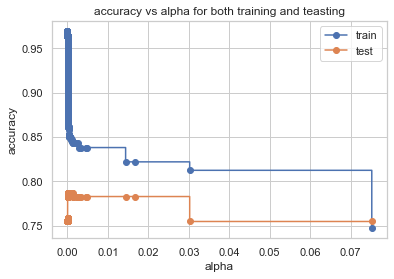

In [190]:
plt.figure(figsize=(10,7))
fig,ax = plt.subplots()
ax.set_xlabel('alpha')
ax.set_ylabel('accuracy')
ax.set_title('accuracy vs alpha for both training and teasting')
ax.plot(ccp_alphas,train_scores,marker='o',label='train',drawstyle='steps-post')
ax.plot(ccp_alphas,test_scores,marker='o',label='test',drawstyle='steps-post')
ax.legend()
plt.show()

In [15]:
model_knn = KNeighborsClassifier()
model_rf = RandomForestClassifier(random_state=0)
model_xgb = XGBClassifier(random_state=0)
model_dt = DecisionTreeClassifier(ccp_alpha= ,random_state=0)
model_svc = SVC()

In [166]:
model_knn.fit(x_train,y_train)
model_rf.fit(x_train,y_train)
model_xgb.fit(x_train,y_train)
model_dt.fit(x_train,y_train)

C:\Users\hp\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:00:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


DecisionTreeClassifier()

In [201]:
score_training=[]
for i in [model_knn,model_rf,model_xgb,model_dt]:
    score_training.append(i.score(x_train,y_train))
    
score_training

[0.8804278235980868,
 0.9695326328475126,
 0.8917259819982676,
 0.8123375889729973]

In [177]:
y_pred_knn = model_knn.predict(x_test)
y_pred_rf = model_rf.predict(x_test)
y_pred_xgb = model_xgb.predict(x_test)
y_pred_dt = model_dt.predict(x_test)

In [208]:
# score_testing=[]
# for i in [model_knn,model_rf,model_xgb,model_dt]:
#     score_testing.append(i.score(x_test,y_test))
    
# score_testing

In [178]:
from sklearn.metrics import accuracy_score
score_testing=[]
for i in [y_pred_knn,y_pred_rf,y_pred_xgb,y_pred_dt]:
    score_testing.append(accuracy_score(y_test,i))
score_testing

[0.7668586919688242,
 0.7824466282616063,
 0.7834632328024399,
 0.7519484920365977]

In [209]:
from sklearn.model_selection import RandomizedSearchCV

In [212]:
# use model_dt or model_rf

In [213]:
# for model_rf
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 20, num = 20)] # number of trees in the random forest
max_features = ['auto', 'sqrt'] # number of features in consideration at every split
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree
min_samples_split = [2, 6, 10] # minimum sample number to split a node
min_samples_leaf = [1, 3, 4] # minimum sample number that can be stored in a leaf node
bootstrap = [True, False] # method used to sample data points

random_grid = {'n_estimators': n_estimators,

'max_features': max_features,

'max_depth': max_depth,

'min_samples_split': min_samples_split,

'min_samples_leaf': min_samples_leaf,

'bootstrap': bootstrap}

In [ ]:
rf_random = RandomizedSearchCV(estimator = model_rf,param_distributions = random_grid,n_iter = 100, cv = 5, verbose=2, random_state=0, n_jobs = -1)

In [ ]:
rf_random.best_params_

In [ ]:
model_rf = RandomForestClassifier(
    #parameters find by random search cv
    random_state=0)

In [ ]:
model_rf.fit(x_train,y_train)

In [ ]:
# score for training data (rf)
model_rf.score(x_train,y_train)

In [ ]:
y_pred = model_rf.predict(x_test)

In [ ]:
# score for testing data (rf)
accuracy_score(y_test,y_pred)

In [ ]:
# for model_dt
random_grid = {
'criterion' : ['gini','entropy'],
'splitter' : ['best','random'],
'max_features' : ["auto", "sqrt", "log2"],
'ccp_alpha' : 0.02
}

In [ ]:
dt_random = RandomizedSearchCV(estimator = model_dt,param_distributions = random_grid,n_iter = 100, cv = 5, verbose=2, random_state=0, n_jobs = -1)

In [ ]:
dt_random.best_params_

In [ ]:
model_dt = DecisionTreeClassifier(
    #parameters find by random search cv
    random_state=0)

In [ ]:
model_dt.fit(x_train,y_train)

In [ ]:
# score for training data (dt)
model_dt.score(x_train,y_train)

In [ ]:
y_pred = model_dt.predict(x_test)

In [ ]:
# score for testing data (dt)
accuracy_score(y_test,y_pred)

In [ ]:
# whichever in these 2 models ie model_rf and model_dt score of training and testing are close and high , we choose that model
# and save that model using pickle

In [214]:
import pickle
pickle.dump(# whichever model we select , open('finalized_model.pkl','wb'))

In [ ]:
pickle.load(open('finalized_model.pkl', 'rb'))

In [216]:
# cassandra
# class and objects
# logging
# Try and except
# Deployment
# arrange and link
# circle ci and docker pipeline
# set pipeline for when user enter his credentials ,all credentials pass through standardise scaling
# set html and css page
# docstring
# everything create as a function

In [9]:
 x = [0 for x in range(1, 38)]

In [12]:
x = []
for i in range(1,38):
    x.append(0)

In [16]:
x[0] = 'age'

In [17]:
x

['age',
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]